 **Analysis Setup**

In [1]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt

# Load the data with Dask
ddf = dd.read_csv('ecommerce_sales_data.csv', assume_missing=True)

# Compute basic statistics to understand the data
print("Data shape:", ddf.shape[0].compute(), "rows")
print("\nColumn data types:")
print(ddf.dtypes)
print("\nFirst few rows:")
print(ddf.head())

Data shape: 100000 rows

Column data types:
TransactionID                   float64
CustomerID                      float64
ProductID                       float64
ProductCategory         string[pyarrow]
Quantity                        float64
Price                           float64
Discount                        float64
TransactionDate         string[pyarrow]
PaymentMethod           string[pyarrow]
CustomerLocation        string[pyarrow]
CustomerAge                     float64
CustomerGender          string[pyarrow]
CustomerIncomeGroup     string[pyarrow]
CustomerLoyaltyScore            float64
dtype: object

First few rows:
   TransactionID  CustomerID  ProductID ProductCategory  Quantity   Price  \
0            1.0      8270.0      295.0        Clothing       1.0  801.66   
1            2.0      1860.0      546.0          Beauty       1.0  225.03   
2            3.0      6390.0      430.0            Toys       2.0  544.99   
3            4.0      6191.0      807.0          Beauty  

**1. Sales Performance by Product Category**

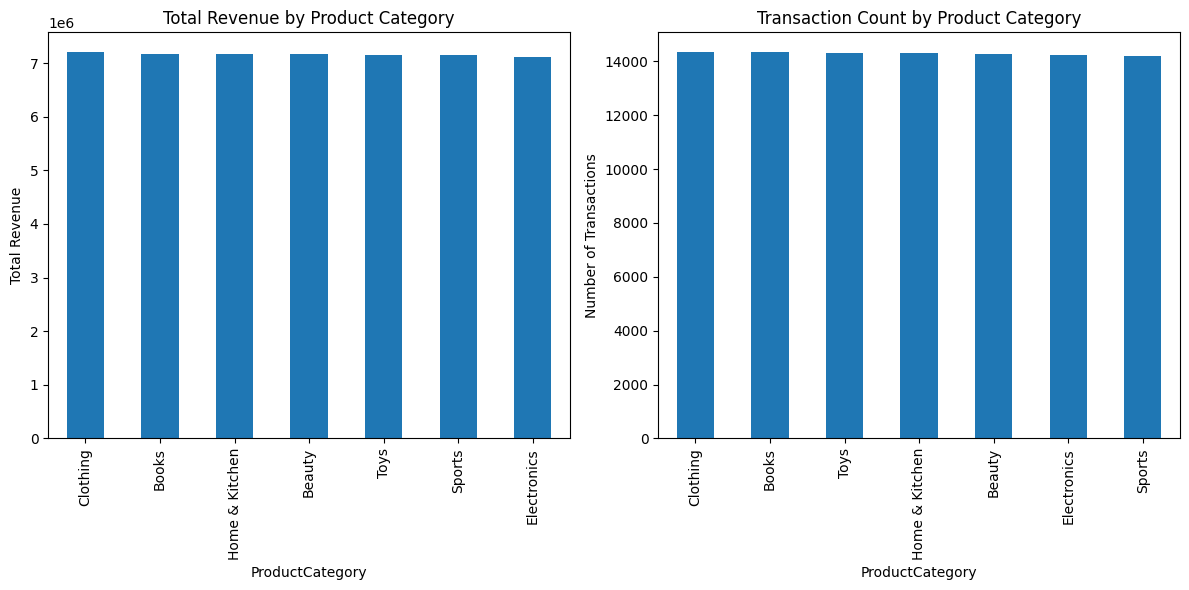

In [2]:
# Calculate total sales by category
category_sales = ddf.groupby('ProductCategory')['Price'].sum().compute()
category_count = ddf['ProductCategory'].value_counts().compute()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
category_sales.sort_values(ascending=False).plot(kind='bar')
plt.title('Total Revenue by Product Category')
plt.ylabel('Total Revenue')

plt.subplot(1, 2, 2)
category_count.sort_values(ascending=False).plot(kind='bar')
plt.title('Transaction Count by Product Category')
plt.ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

**2. Payment Method Preferences**

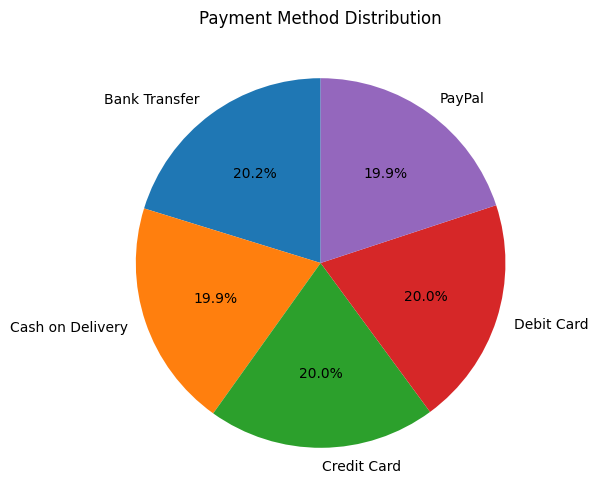

In [10]:
import matplotlib.pyplot as plt

# Ensure it's a proper Pandas Series
payment_methods = ddf['PaymentMethod'].value_counts().compute()

# Convert to Pandas explicitly if needed
payment_methods = payment_methods.astype(int)

plt.figure(figsize=(8, 6))
payment_methods.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Payment Method Distribution')
plt.ylabel('')  # Remove default y-label
plt.show()


**3. Customer Demographics Analysis**

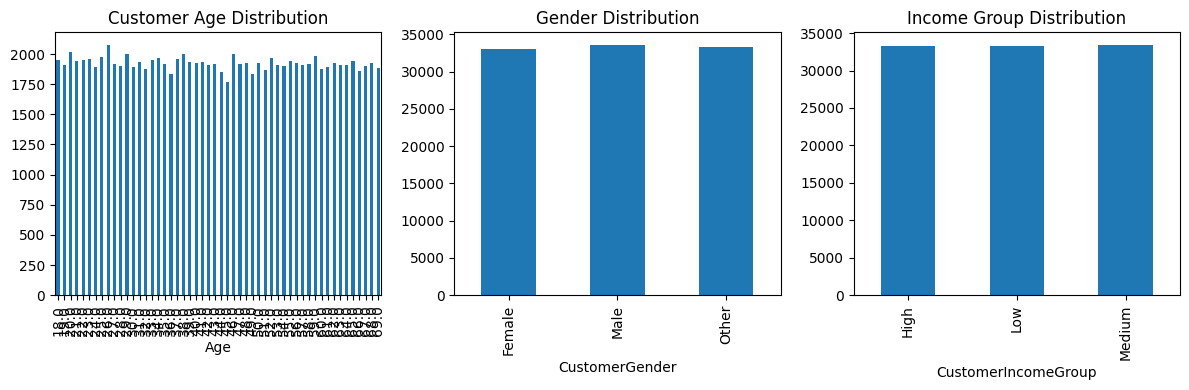

In [11]:
# Age distribution
age_dist = ddf['CustomerAge'].value_counts().compute().sort_index()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
age_dist.plot(kind='bar')
plt.title('Customer Age Distribution')
plt.xlabel('Age')

# Gender distribution
plt.subplot(1, 3, 2)
ddf['CustomerGender'].value_counts().compute().plot(kind='bar')
plt.title('Gender Distribution')

# Income group distribution
plt.subplot(1, 3, 3)
ddf['CustomerIncomeGroup'].value_counts().compute().plot(kind='bar')
plt.title('Income Group Distribution')

plt.tight_layout()
plt.show()

**4. Time-based Analysis**

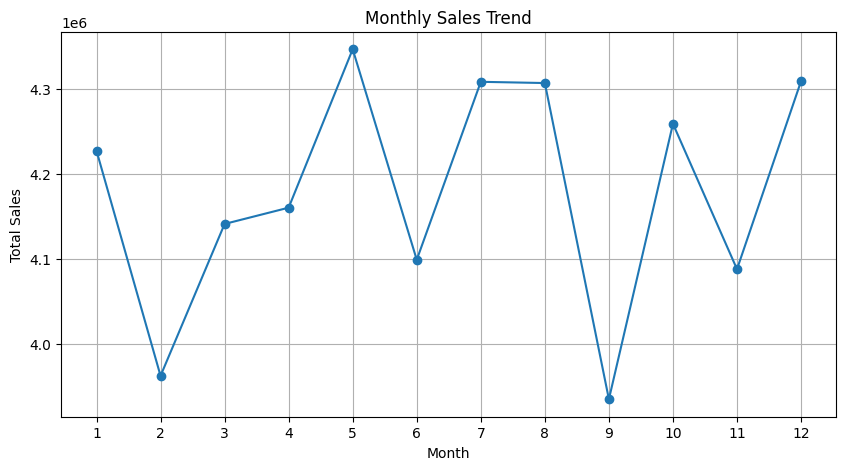

In [12]:
# Convert to datetime and extract month
ddf['TransactionDate'] = dd.to_datetime(ddf['TransactionDate'])
ddf['Month'] = ddf['TransactionDate'].dt.month

monthly_sales = ddf.groupby('Month')['Price'].sum().compute()

plt.figure(figsize=(10, 5))
monthly_sales.plot(kind='line', marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13))
plt.grid()
plt.show()

**5. Discount Impact Analysis**

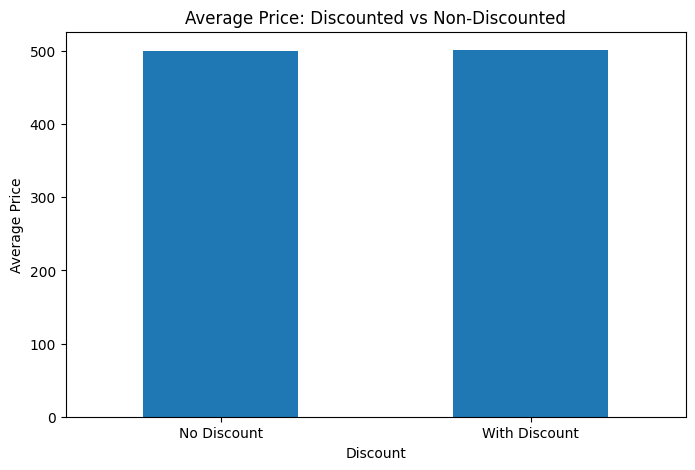

In [13]:
# Calculate average price with and without discount
discount_impact = ddf.groupby(ddf['Discount'] > 0)['Price'].mean().compute()

plt.figure(figsize=(8, 5))
discount_impact.plot(kind='bar')
plt.title('Average Price: Discounted vs Non-Discounted')
plt.ylabel('Average Price')
plt.xticks([0, 1], ['No Discount', 'With Discount'], rotation=0)
plt.show()

**Customer Segmentation by Loyalty and Spending**

In [14]:
# Calculate customer-level metrics
customer_stats = ddf.groupby('CustomerID').agg({
    'Price': ['sum', 'mean', 'count'],
    'CustomerLoyaltyScore': 'mean'
}).compute()

# Rename columns for clarity
customer_stats.columns = ['TotalSpend', 'AvgOrderValue', 'PurchaseCount', 'AvgLoyaltyScore']

# Segment customers
customer_stats['Segment'] = pd.cut(customer_stats['TotalSpend'],
                                  bins=[0, 1000, 5000, float('inf')],
                                  labels=['Low', 'Medium', 'High'])

segment_summary = customer_stats.groupby('Segment').mean()

print("\nCustomer Segment Analysis:")
print(segment_summary)


Customer Segment Analysis:
          TotalSpend  AvgOrderValue  PurchaseCount  AvgLoyaltyScore
Segment                                                            
Low       703.423333     228.336519       3.388889        47.548204
Medium   3792.172842     458.473909       8.442131        50.105263
High     6834.005019     531.577537      13.005299        49.939244


<ipython-input-14-19bbea14ece2>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_summary = customer_stats.groupby('Segment').mean()


**Product Category Profitability**

In [15]:
# Calculate revenue and average discount by category
category_stats = ddf.groupby('ProductCategory').agg({
    'Price': 'sum',
    'Discount': 'mean',
    'Quantity': 'sum'
}).compute()

category_stats['AvgDiscount'] = category_stats['Discount'] * 100
category_stats['Revenue'] = category_stats['Price']
category_stats['UnitsSold'] = category_stats['Quantity']

print("\nCategory Performance Metrics:")
print(category_stats[['Revenue', 'UnitsSold', 'AvgDiscount']].sort_values('Revenue', ascending=False))


Category Performance Metrics:
                    Revenue  UnitsSold  AvgDiscount
ProductCategory                                    
Clothing         7215695.40    35963.0    14.988860
Books            7180883.26    36054.0    14.908032
Home & Kitchen   7168764.43    35738.0    15.001539
Beauty           7165829.42    35644.0    15.073755
Toys             7151087.61    35717.0    15.015590
Sports           7145668.06    35460.0    14.956402
Electronics      7119071.13    35399.0    15.029815
